# OilyGiant Mining New Well Selection

Our task is to find the best place for a new well. We will collect the oil well parameters in the selected region, build a model for predicting the volume of reserves in the new wells, pick the oil wells with the highest estimated values, and pick the region with the highest total profit for the selected oil wells. We have data on oil samples in three regions that we will be analyzing to pick the region with the highest profit margin.

## Download and prepare the data

In [1]:
#import all of the libraries and packages we will be using in this project
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
#import the data sets
df_0 = pd.read_csv('C:/Users/susan/Documents/TripleTen/new_well_selection/geo_data_0.csv')
df_1 = pd.read_csv('C:/Users/susan/Documents/TripleTen/new_well_selection/geo_data_1.csv')
df_2 = pd.read_csv('C:/Users/susan/Documents/TripleTen/new_well_selection/geo_data_2.csv')

In [3]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
#check for duplicates
df_0.duplicated().sum()

0

In [10]:
df_1.duplicated().sum()

0

In [11]:
df_2.duplicated().sum()

0

The data for each of the three regions has no missing values or duplicates, and all column names and datatypes appear appropriate. The id column will not be helpful in our model, so we will drop those columns in each data frame.

In [12]:
df_0 = df_0.drop('id', axis=1)
df_1 = df_1.drop('id', axis=1)
df_2 = df_2.drop('id', axis=1)
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


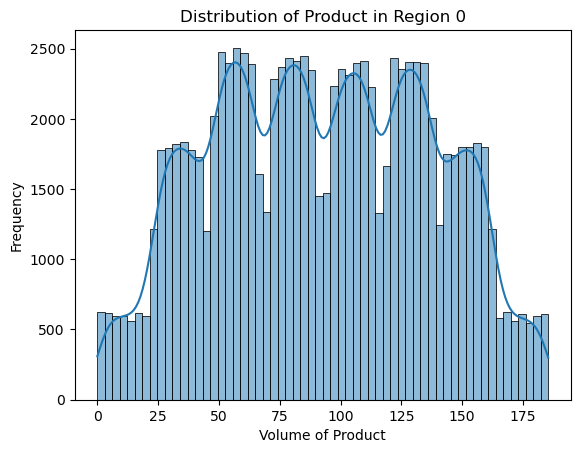

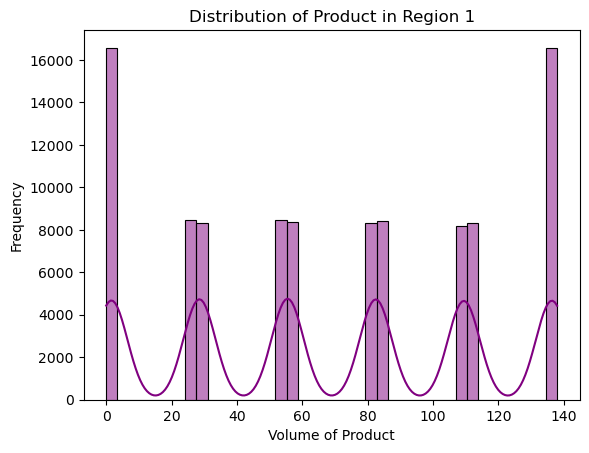

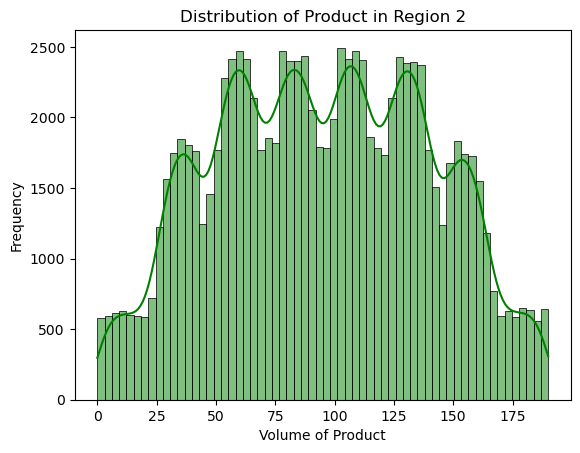

In [13]:
#plot a histogram of the distribution of product volume in each dataframe

sns.histplot(data=df_0, x='product', kde=True)
plt.title("Distribution of Product in Region 0")
plt.xlabel('Volume of Product')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data=df_1, x='product', color='purple', kde=True)
plt.title("Distribution of Product in Region 1")
plt.xlabel('Volume of Product')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data=df_2, x='product', color='green', kde=True)
plt.title("Distribution of Product in Region 2")
plt.xlabel('Volume of Product')
plt.ylabel('Frequency')
plt.show()

The distribution appears to be normal in both Region 0 and Region 2. The distribution for Region 1 appears to be discrete, which could be from the procedures of how the data was collected from those oil wells such as rounding the data or having distinct categories. However, there appear to be no outliers or other anomalies that would skew the data in any of the regions, so we can feel comfortable that we are ready to move forward with training our models.

## Train and test the model for each region

Region 0

In [14]:
#split the data in to a training set and validation set at a ratio of 75:25

#extract the features and target
features_0 = df_0.drop(['product'], axis=1)
target_0 = df_0['product']

#split the features and targets into training and validation sets
features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(features_0, target_0, test_size=0.25, random_state=1234)

#train the model and make predictions for the validation set
model_0 = LinearRegression().fit(features_0_train, target_0_train)
predictions_0_valid = model_0.predict(features_0_valid)

#print the average volume of predicted reserves and model RMSE
result_0 = mean_squared_error(target_0_valid, predictions_0_valid)**0.5
print("RMSE:", result_0)
print("Average volume of predicted reserves:", predictions_0_valid.mean())

RMSE: 37.562394183637785
Average volume of predicted reserves: 92.43045952558441


Region 1

In [15]:
#split the data in to a training set and validation set at a ratio of 75:25
features_1 = df_1.drop(['product'], axis=1)
target_1 = df_1['product']

#split the features and targets into training and validation sets
features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(features_1, target_1, test_size=0.25, random_state=1234)

#train the model and make predictions for the validation set
model_1 = LinearRegression().fit(features_1_train, target_1_train)
predictions_1_valid = model_1.predict(features_1_valid)

#print the average volume of predicted reserves and model RMSE
result_1 = mean_squared_error(target_1_valid, predictions_1_valid)**0.5
print("RMSE:", result_1)
print("Average volume of predicted reserves:", predictions_1_valid.mean())

RMSE: 0.8939344738117712
Average volume of predicted reserves: 68.80248249798366


Region 2

In [16]:
#split the data in to a training set and validation set at a ratio of 75:25
features_2 = df_2.drop(['product'], axis=1)
target_2 = df_2['product']

#split the features and targets into training and validation sets
features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(features_2, target_2, test_size=0.25, random_state=1234)

#train the model and make predictions for the validation set
model_2 = LinearRegression().fit(features_2_train, target_2_train)
predictions_2_valid = model_2.predict(features_2_valid)

#print the average volume of predicted reserves and model RMSE
result_2 = mean_squared_error(target_2_valid, predictions_2_valid)**0.5
print("RMSE:", result_2)
print("Average volume of predicted reserves:", predictions_2_valid.mean())

RMSE: 40.10318099258418
Average volume of predicted reserves: 94.91573817913459


In [17]:
target_0.mean()

92.50000000000001

In [18]:
target_1.mean()

68.82500000000002

In [19]:
target_2.mean()

95.00000000000004

The RMSE value for Region 0 37.56, while the average predicted volume is 92.4. Region 1 has an RMSE value of 0.89 with an average predicted volume of 68.8, and Region 2 has an RMSE of 40.10 with an average predicted volume of 94.9. This shows that the RMSE is very high for Region 0 and 2, and those models are not performing as accurately as the model for Region 1 with a much smaller RMSE. The mean predicted volume does fall into alignment with the actual average of volume produced in each region, so all of the models are working.

## Prepare for Profit Calculation

In [20]:
#Store all key values for calculations in separate variables
revenue_per_barrel = 4500
cost_per_well = 500000
budget = 100_000_000
top_wells = 200
num_wells=500

In [21]:
#Calculate sufficient volume of reserves sufficient for developing a new well without losses
break_even_volume = cost_per_well / revenue_per_barrel
break_even_volume

111.11111111111111

In [22]:
#Compare the break-even value with the average volume of reserves in each region
ave_reserves_0 = target_0.mean()
ave_reserves_1 = target_1.mean()
ave_reserves_2 = target_2.mean()

print("Break-even volume needed:", break_even_volume)
print("Average reserves in Region 0:", ave_reserves_0)
print("Average reserves in Region 1:", ave_reserves_1)
print("Average reserves in Region 2:", ave_reserves_2)

Break-even volume needed: 111.11111111111111
Average reserves in Region 0: 92.50000000000001
Average reserves in Region 1: 68.82500000000002
Average reserves in Region 2: 95.00000000000004


It looks like Region 2 has the closest amount of reserves to reach the break-even volume.

## Calculate Profit from a set of selected oil wells and model predictions


In [23]:
#write a function to calculate profit from a set of selected oil wells and model predictions
regions = [(predictions_0_valid, target_0_valid, 'Region 0'), (predictions_1_valid, target_1_valid, 'Region 1'), (predictions_2_valid, target_2_valid, 'Region 2')]

def calculate_profit(predictions, targets, cost_per_well=500000, top_wells=200):
    results = pd.DataFrame({'predicted': predictions, 'actual': targets})
    
    selected_wells = results.sort_values(by='predicted', ascending=False).head(top_wells)
    
    total_predicted_reserves = selected_wells['predicted'].sum()
    total_actual_reserves = selected_wells['actual'].sum()
   
    profit = (total_actual_reserves * revenue_per_barrel) - (top_wells * cost_per_well)
        
    return profit, total_predicted_reserves, total_actual_reserves
    
for predictions, targets, region_name in regions:
    profit, total_predicted_reserves, total_actual_reserves = calculate_profit(predictions, targets)
    
    print(f'Region {region_name}')
    print(f'Calculated profit: {profit:,.2f}')
    print(f'Total Predicted Reserves: {total_predicted_reserves:,.2f}')
    print(f'Total Actual Reserves: {total_actual_reserves:,.2f}\n')      
    

Region Region 0
Calculated profit: 34,240,263.20
Total Predicted Reserves: 30,849.15
Total Actual Reserves: 29,831.17

Region Region 1
Calculated profit: 24,150,866.97
Total Predicted Reserves: 27,738.86
Total Actual Reserves: 27,589.08

Region Region 2
Calculated profit: 25,549,554.24
Total Predicted Reserves: 29,996.33
Total Actual Reserves: 27,899.90



Region 0 was predicted to have the hightest amount of reserves, and the profit produced in its top 200 wells is the highest of all the regions at $34,240,263.20.

## Calculate Risks and Profit for each region

In [24]:
#Use bootstrapping with 1000 samples to find the distribution of profit, average profit, 95% confidence interval, and risk of losses

def bootstrap_profit(predictions, targets, cost_per_well, sample_size=500, n_bootstrap=1000):
    profits = []
    
    for i in range(n_bootstrap):
        boot_df = pd.DataFrame({'predicted': predictions, 'actual': targets})   
        sampled_predictions = boot_df['predicted'].sample(sample_size, replace=True)
        sampled_targets = boot_df['actual'].loc[sampled_predictions.index]
        profit, _, _ = calculate_profit(sampled_predictions, sampled_targets, cost_per_well, top_wells=200)
        profits.append(profit)
        
    return pd.Series(profits)    
   
def analyze_profits(profits):
    average_profit = profits.mean()
    ci_lower = profits.quantile(0.025)
    ci_upper = profits.quantile(0.975)
    risk_loss = (profits < 0).mean() * 100
    
    
    return average_profit, ci_lower, ci_upper, risk_loss

#use the bootstrap_profit function for each region
regions = [(predictions_0_valid, target_0_valid, 'Region 0'), (predictions_1_valid, target_1_valid, 'Region 1'), (predictions_2_valid, target_2_valid, 'Region 2')]
bootstrap_results = []

for predictions, targets, region_name in regions:
    boot_profits = bootstrap_profit(predictions, targets, cost_per_well)
    average_profit, ci_lower, ci_upper, risk_loss = analyze_profits(boot_profits)
    
    bootstrap_results.append((region_name, average_profit, ci_lower, ci_upper, risk_loss))
    
print("\n--- Regional Profit Analysis ---\n")
for region_name, average_profit, ci_lower, ci_upper, risk_loss in bootstrap_results:
    print(f"{region_name}:")
    print(f" Average Profit: ${average_profit:,.2f}")
    print(f" 95% Confidence Interval: ${ci_lower:,.2f}, ${ci_upper:,.2f}")
    print(f" Risk of Loss: {risk_loss:,.2f}%\n")


--- Regional Profit Analysis ---

Region 0:
 Average Profit: $4,095,020.49
 95% Confidence Interval: $-841,858.65, $9,191,835.91
 Risk of Loss: 5.70%

Region 1:
 Average Profit: $4,345,863.50
 95% Confidence Interval: $208,627.29, $8,130,242.54
 Risk of Loss: 2.20%

Region 2:
 Average Profit: $3,439,046.50
 95% Confidence Interval: $-1,465,474.25, $8,340,272.63
 Risk of Loss: 9.80%



# Conclusion

We began this task by downloading three datasets of oil samples in three different regions. We checked for missing values, duplicates, and other problems with the data. We removed the unnecessary columns and then looked at the distribution of the volume of oil reserves in each dataframe. We found no inidication of outliers or other anomalies in the data.

We then split the data into training and validation sets in order to train a linear regression model for each region. We found that the model for Region 1 was the most accurately performing model, but all of the models predicted mean volumes of reserves that were similar to the actual mean volume.

Using the budget conditions, we found that the volume of reserves sufficient for developing a new well without losses is 111.11 thousand barrels. Region 2 had the closest average volume of reserves to reach that break-even amount with 95 thousand barrels.

We then calculated the predicted profit for each region using the 200 top performing wells in each region. Region 0 has the highest profit produced in its top 200 wells at an estimated $34,240,263.20.

And finally, we used the bootstrap technique with 1000 samples to find the distribution of profit.

After our analysis, we would recommend Region 1 as the region to develop more oil wells. While Region 0 has the greatest profit produced in its top 200 wells, Regions 0 and 2 have a risk of loss greater than 2.5 percent. Region 1 has the highest average profit, and the risk of loss for Region 1 is below 2.5 percent. These predictions seem valid as the model RSME for Region 1 was also the best at 0.89 showing that these predictions are valuable.